## This notebook aims to visualize the different asset distributions produced by CGAN

In [1]:
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist
import sys
from tqdm import tqdm

parent_dir = os.path.abspath(os.path.join(os.getcwd(), "../../../"))
sys.path.insert(0, parent_dir)

from utilities.gan_plotting import extensive_plotting
from utilities.backtesting_plots import backtest_var_single_asset
from utilities.gan_plotting import load_generated_returns
from backtesting.perform_var_tests import perform_var_backtesting_tests
from backtesting.perform_distribution_tests import perform_distribution_tests
from utilities.gan_plotting import create_rolling_empirical

from dotenv.main import load_dotenv
load_dotenv(override=True)
import os


In [2]:
import os
print(os.getcwd())

c:\Users\nicka\master-thesis\internal_models\GANs\tuned_GANS


### Parameters

In [3]:
assets_0 = int(os.getenv("INIT_ASSETS"))
liabilities_0 = int(os.getenv("INIT_ASSETS")) * float(os.getenv("FRAC_LIABILITIES"))
num_simulations = int(os.getenv("N_SIMULATIONS"))
bof_0 = assets_0 - liabilities_0

## Note to self -- We only test assets MSCIWORLD, HY and EONIA

In [4]:
def fetch_data_df():
    # Load the data
    df = pd.read_csv('../../../data/final_daily_returns_asset_classes.csv', index_col=0, parse_dates=True)
    df.index = pd.to_datetime(df.index)
    start_test_date = os.getenv("START_TEST_DATE")
    
    if start_test_date is None:
        raise ValueError("Environment variable 'START_TEST_DATE' is not set.")

    start_test_date = pd.to_datetime(start_test_date)

    columns = [0, 1, 2, 3, 4, 5, 6]#[0,1,2,4]
    selected_columns = df.iloc[:, columns]  # Remember: Python uses 0-based indexing

    pre_test_df = selected_columns[selected_columns.index < start_test_date]
    test_df = selected_columns[selected_columns.index >= start_test_date].iloc[:252]
    
    return pre_test_df, test_df

returns_df, test_returns_df = fetch_data_df()

In [5]:
asset_names = returns_df.columns

num_assets = returns_df.shape[1]
weights = np.full(num_assets, 1 / num_assets)  

## TRAINING CGAN

In [ ]:
from astrid_GAN import AstridGAN
from nova_GAN import NovaGAN

gan_dict = {}

# Dictionary to store generated scenarios by asset and date.
# Structure: { asset_name: { date: generated_scenarios, ... }, ... }
scenarios_results = {}

for asset_name in tqdm(returns_df.columns, desc="Training GANs", unit="asset"):
    print(f"Training GAN for {asset_name}...")
    asset_returns = returns_df[asset_name]
    
    gan = NovaGAN(asset_returns, asset_name)
    gan.train()
    print(f"Finished training GAN for {asset_name}.\n")
    
    scenarios = gan.generate_scenarios(num_scenarios=10000)
    print(f"Finished generating scenarios for {asset_name}.\n")
    
    gan_dict[asset_name] = gan

    initial_date = returns_df.index[-1]
    scenarios_results.setdefault(asset_name, {})[initial_date] = scenarios
    print(f"{asset_name}: Stored initial generated scenarios for {initial_date}.")

# Online training during the test period
# Assume test_returns_df contains daily returns for the test period
'''
for test_day in test_returns_df.index:
    for asset_name in test_returns_df.columns:
        new_return = test_returns_df.loc[test_day, asset_name]
        gan = gan_dict[asset_name]
        
        # Process the new return (online_training handles fine-tuning or full retraining as needed)
        print("date", test_day)
        gan.online_training(new_return)
        print(f"{asset_name}: Processed online update for new return on {test_day}.")
        
        # Generate scenarios with the updated GAN
        scenarios = gan.generate_scenarios(save=False, num_scenarios=10000)
        
        # Store the generated scenarios for this test day
        scenarios_results.setdefault(asset_name, {})[test_day] = scenarios
        print(f"{asset_name}: Stored generated scenarios for {test_day}.")'
'''

# At this point, scenarios_results contains the generated scenario distribution for each asset keyed by date.

for asset_name in tqdm(test_returns_df.columns, desc="Updating GANs", unit="asset"):
    asset_returns = returns_df[asset_name]
    
    for test_day in test_returns_df.index:
        new_return = test_returns_df.loc[test_day, asset_name]
        new_row = pd.DataFrame({asset_name: [new_return]}, index=[test_day])
        asset_returns = pd.concat([asset_returns, new_row])
        
        gan = NovaGAN(asset_returns, asset_name)
        
        # You might want to add a print statement inside the GAN training loop
        # to check the batch size, for example, in the beginning of gan.train():
        gan.train()
        
        print(f"{asset_name}: Processed online update for new return on {test_day}.")
        
        scenarios = gan.generate_scenarios(save=False, num_scenarios=10000)
        scenarios_results.setdefault(asset_name, {})[test_day] = scenarios
        
        print(f"{asset_name}: Stored generated scenarios for {test_day}.")


Training GANs:   0%|          | 0/7 [00:00<?, ?asset/s]

Training GAN for REEL...


In [ ]:
for asset_name in test_returns_df.columns:
    complete_returns = returns_df[asset_name]
    for test_day in test_returns_df.index:
        new_return = test_returns_df.loc[test_day, asset_name]
        
        new_row = pd.DataFrame({asset_name: [new_return]}, index=[test_day])
        complete_returns = pd.concat([complete_returns, new_row])

Lenght of complete returns 3440
Lenght of complete returns 3441
Lenght of complete returns 3442
Lenght of complete returns 3443
Lenght of complete returns 3444
Lenght of complete returns 3445
Lenght of complete returns 3446
Lenght of complete returns 3447
Lenght of complete returns 3448
Lenght of complete returns 3449
Lenght of complete returns 3450
Lenght of complete returns 3451
Lenght of complete returns 3452
Lenght of complete returns 3453
Lenght of complete returns 3454
Lenght of complete returns 3455
Lenght of complete returns 3456
Lenght of complete returns 3457
Lenght of complete returns 3458
Lenght of complete returns 3459
Lenght of complete returns 3460
Lenght of complete returns 3461
Lenght of complete returns 3462
Lenght of complete returns 3463
Lenght of complete returns 3464
Lenght of complete returns 3465
Lenght of complete returns 3466
Lenght of complete returns 3467
Lenght of complete returns 3468
Lenght of complete returns 3469
Lenght of complete returns 3470
Lenght o

In [ ]:
returns_df.tail()

In [ ]:
from internal_models.multivariate_GAN.simple_gan_portfolio import SimpleGANPortfolio
from internal_models.multivariate_GAN.students_copula_GAN import StudentCopula

## We need to get rolling Delta BOF

In [ ]:
entire_df = pd.concat([returns_df, test_returns_df])

entire_df.tail()

,REEL,PE,MSCIWORLD,IG,GOV,HY,EONIA
Date,,,,,,,
2020-12-21,-0.021011,-0.009039,-0.006195,0.000340,0.000378,-0.002352,-0.000046
2020-12-22,0.010600,0.007414,0.002932,0.001471,0.001006,0.001066,-0.000015
2020-12-23,0.021998,0.011317,0.001690,-0.002486,-0.004044,0.000866,-0.000016
2020-12-24,0.004674,0.002335,0.003177,0.001586,0.000048,0.000539,-0.000015
2020-12-28,0.000842,0.000271,0.004125,0.000775,0.002064,0.002635,-0.000046


In [ ]:
test_start_date = test_returns_df.index.min()
test_end_date = test_returns_df.index.max()
print("Test end date:", test_end_date)

# Find the index location of the test_start_date in entire_df
idx = entire_df.index.get_loc(test_end_date)
idx_start = entire_df.index.get_loc(test_start_date)

# Slice 252 rows before that index
historical_df = entire_df.iloc[idx_start - 252:]
historical_df.head()

Test end date: 2020-12-28 00:00:00


,REEL,PE,MSCIWORLD,IG,GOV,HY,EONIA
Date,,,,,,,
2019-01-03,0.000449,-0.016792,-0.017998,0.003209,-0.002739,0.000322,-0.00001
2019-01-04,0.017480,0.029982,0.025947,-0.004488,-0.002372,0.006997,-0.00001
2019-01-07,0.004902,0.016009,0.003607,0.000024,-0.001484,0.006122,-0.00003
2019-01-08,0.015357,0.012384,0.010125,-0.000592,-0.001053,0.004209,-0.00001
2019-01-09,-0.003836,0.003621,0.001916,0.001019,0.001938,0.004650,-0.00001


In [ ]:
historical_df.tail()

,REEL,PE,MSCIWORLD,IG,GOV,HY,EONIA
Date,,,,,,,
2020-12-21,-0.021011,-0.009039,-0.006195,0.000340,0.000378,-0.002352,-0.000046
2020-12-22,0.010600,0.007414,0.002932,0.001471,0.001006,0.001066,-0.000015
2020-12-23,0.021998,0.011317,0.001690,-0.002486,-0.004044,0.000866,-0.000016
2020-12-24,0.004674,0.002335,0.003177,0.001586,0.000048,0.000539,-0.000015
2020-12-28,0.000842,0.000271,0.004125,0.000775,0.002064,0.002635,-0.000046


In [ ]:
entire_df.tail()

,REEL,PE,MSCIWORLD,IG,GOV,HY,EONIA
Date,,,,,,,
2020-12-21,-0.021011,-0.009039,-0.006195,0.000340,0.000378,-0.002352,-0.000046
2020-12-22,0.010600,0.007414,0.002932,0.001471,0.001006,0.001066,-0.000015
2020-12-23,0.021998,0.011317,0.001690,-0.002486,-0.004044,0.000866,-0.000016
2020-12-24,0.004674,0.002335,0.003177,0.001586,0.000048,0.000539,-0.000015
2020-12-28,0.000842,0.000271,0.004125,0.000775,0.002064,0.002635,-0.000046


# CASE 1

- We first calculate realized delta BOF for a given window

In [ ]:
# CALCULATE DELTA BOF ARRAY
eonia = historical_df.iloc[:, -1]
bof_0 = assets_0 - liabilities_0

portfolio_returns = (historical_df * weights).sum(axis=1)

portfolio_value = assets_0 * (1 + portfolio_returns).cumprod()

liabilities = liabilities_0 * (1 + eonia).cumprod()

bof = portfolio_value - liabilities

daily_delta_bof = bof.diff().fillna(0)


rolling_delta_bof = daily_delta_bof.rolling(window=252).sum()


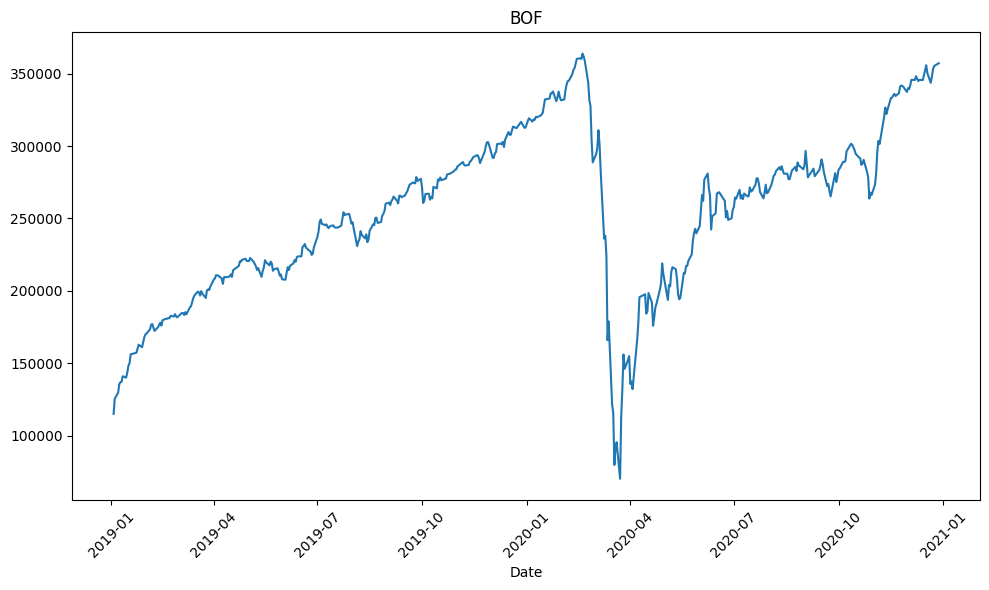

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(bof.index, bof.values, linestyle='-')
plt.xlabel("Date")
plt.ylabel("")
plt.title("BOF")
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

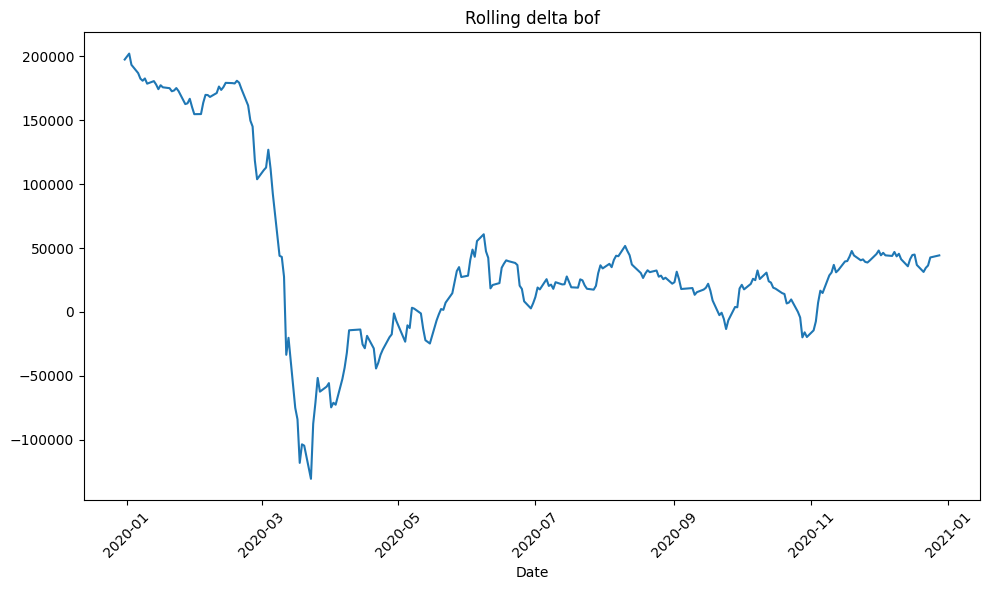

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(rolling_delta_bof.index, rolling_delta_bof.values, linestyle='-')
plt.xlabel("Date")
plt.ylabel("")
plt.title("Rolling delta bof")
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

# Case 2

Same, assuming constant BOF0

In [ ]:
bof.loc["2019-12-31"]

np.float64(312804.51417605917)

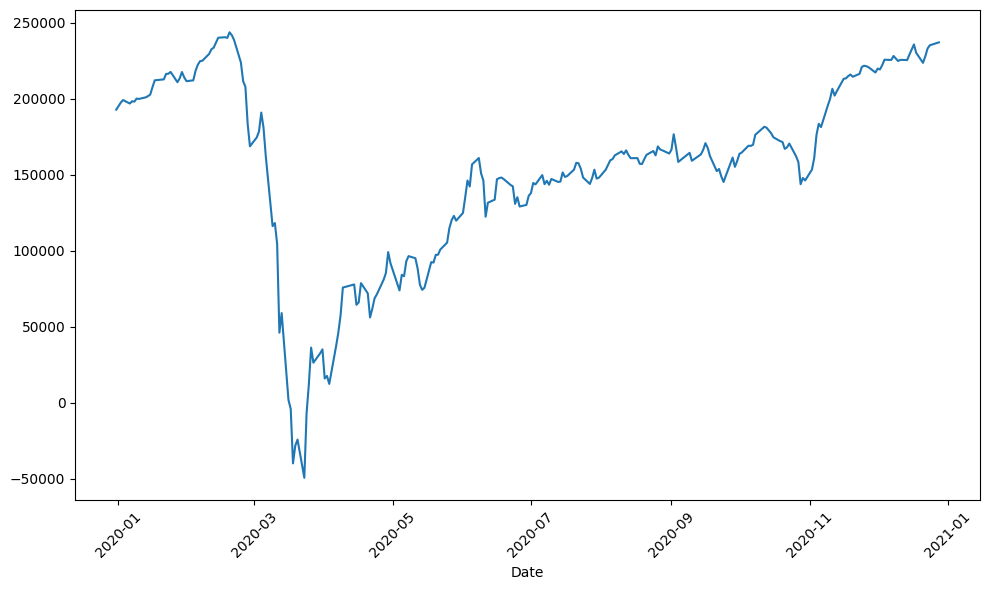

In [ ]:
bof_case_ii = bof.loc["2019-12-31":]

delta_bof_case_ii = bof_case_ii - bof_0

plt.figure(figsize=(10, 6))
plt.plot(delta_bof_case_ii.index, delta_bof_case_ii.values, linestyle='-')
plt.xlabel("Date")
plt.ylabel("")
plt.title("")
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

In [ ]:
asset_names = list(returns_df.columns)

# scenarios_results is assumed to be a nested dictionary:
# { asset_name: { date: scenarios_array, ... }, ... }
# where scenarios_array has shape (n_simulations, window_size)
#
# We want to build a matrix for each date of shape (n_simulations, n_assets),
# where each column is the last value (i.e. cumulative return) from the corresponding asset’s scenarios.

# Get the list of dates for which we have generated scenarios.
# (Assuming the dates are the same across assets, here we take the dates from the first asset.)
all_dates = sorted(list(scenarios_results[asset_names[0]].keys()))

# Dictionary to store SCR for each date.
portfolio_scr_results = {}  # key: date, value: scr

for date in all_dates:
    gan_samples_cols = []
    for asset in asset_names:
        # Retrieve the scenarios for the asset at this date.
        asset_scenarios = scenarios_results[asset][date]  # expected shape: (n_simulations, window_size)
        # Use the last column to represent the cumulative return.
        asset_cum = np.prod(1 + asset_scenarios, axis=1) - 1
        gan_samples_cols.append(asset_cum.reshape(-1, 1))

    # Stack horizontally so that each column corresponds to one asset.
    gan_samples = np.hstack(gan_samples_cols)  # shape: (n_simulations, n_assets)
    
    # Create a portfolio with the aggregated GAN samples and the specified weights.

    bof_0_case_i = bof.iloc[bof.index.get_loc(date) - 252]

    portfolio = SimpleGANPortfolio(gan_samples, weights, bof0_casei=bof_0_case_i)
    _, scr = portfolio.calculate_distribution_and_scr(case=2)
    
    portfolio_scr_results[date] = scr
    print(f"Date {date}: SCR = {scr}")


Date 2019-12-31 00:00:00: SCR = -482383.2291822594
Date 2020-01-02 00:00:00: SCR = -429929.32919229224
Date 2020-01-03 00:00:00: SCR = -451925.7901246094
Date 2020-01-06 00:00:00: SCR = -422513.799899638
Date 2020-01-07 00:00:00: SCR = -448912.4679238837
Date 2020-01-08 00:00:00: SCR = -475213.87785754335
Date 2020-01-09 00:00:00: SCR = -451895.70131247916
Date 2020-01-10 00:00:00: SCR = -438085.8988914162
Date 2020-01-13 00:00:00: SCR = -428665.36494574416
Date 2020-01-14 00:00:00: SCR = -442639.7750056211
Date 2020-01-15 00:00:00: SCR = -439870.62517644605
Date 2020-01-16 00:00:00: SCR = -447662.1196583937
Date 2020-01-17 00:00:00: SCR = -472518.7693435122
Date 2020-01-20 00:00:00: SCR = -449925.48658670695
Date 2020-01-21 00:00:00: SCR = -461128.25125588
Date 2020-01-22 00:00:00: SCR = -504603.1534781837
Date 2020-01-23 00:00:00: SCR = -490128.99580921995
Date 2020-01-24 00:00:00: SCR = -482429.9655187988
Date 2020-01-27 00:00:00: SCR = -441368.0244587735
Date 2020-01-28 00:00:00: S

c:\Users\nicka\master-thesis\packages\Lib\site-packages\numpy\_core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\nicka\master-thesis\packages\Lib\site-packages\numpy\lib\_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Date 2020-03-13 00:00:00: SCR = nan
Date 2020-03-16 00:00:00: SCR = nan
Date 2020-03-17 00:00:00: SCR = nan
Date 2020-03-18 00:00:00: SCR = nan
Date 2020-03-19 00:00:00: SCR = nan
Date 2020-03-20 00:00:00: SCR = nan
Date 2020-03-23 00:00:00: SCR = nan


c:\Users\nicka\master-thesis\packages\Lib\site-packages\numpy\_core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Date 2020-03-24 00:00:00: SCR = nan
Date 2020-03-25 00:00:00: SCR = nan
Date 2020-03-26 00:00:00: SCR = nan
Date 2020-03-27 00:00:00: SCR = nan
Date 2020-03-30 00:00:00: SCR = nan
Date 2020-03-31 00:00:00: SCR = nan
Date 2020-04-01 00:00:00: SCR = nan
Date 2020-04-02 00:00:00: SCR = nan
Date 2020-04-03 00:00:00: SCR = nan
Date 2020-04-06 00:00:00: SCR = nan
Date 2020-04-07 00:00:00: SCR = nan
Date 2020-04-08 00:00:00: SCR = nan
Date 2020-04-09 00:00:00: SCR = nan
Date 2020-04-14 00:00:00: SCR = nan
Date 2020-04-15 00:00:00: SCR = nan
Date 2020-04-16 00:00:00: SCR = nan
Date 2020-04-17 00:00:00: SCR = nan
Date 2020-04-20 00:00:00: SCR = nan
Date 2020-04-21 00:00:00: SCR = nan
Date 2020-04-22 00:00:00: SCR = nan
Date 2020-04-23 00:00:00: SCR = nan
Date 2020-04-24 00:00:00: SCR = nan
Date 2020-04-27 00:00:00: SCR = nan
Date 2020-04-28 00:00:00: SCR = nan
Date 2020-04-29 00:00:00: SCR = nan
Date 2020-04-30 00:00:00: SCR = nan
Date 2020-05-04 00:00:00: SCR = nan
Date 2020-05-05 00:00:00: SC

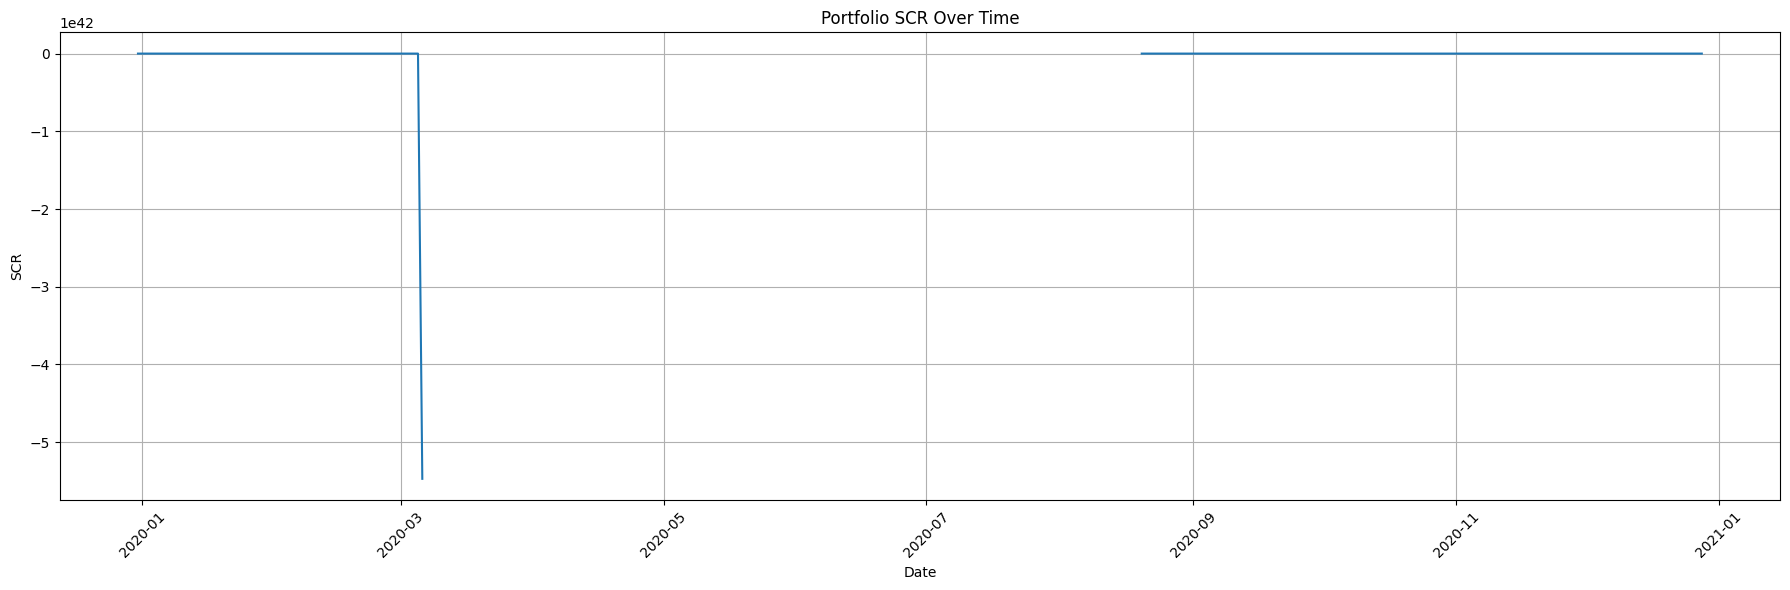

In [ ]:
# Assume portfolio_scr_results is a dictionary with dates as keys and SCR values as values.
# First, sort the dates (this assumes the keys are either datetime objects or strings that sort chronologically)
sorted_dates = sorted(portfolio_scr_results.keys())
scr_values = [portfolio_scr_results[date] for date in sorted_dates]

plt.figure(figsize=(18, 6))
plt.plot(sorted_dates, scr_values, linestyle='-')
plt.xlabel("Date")
plt.ylabel("SCR")
plt.title("Portfolio SCR Over Time")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
test_start_date = test_returns_df.index[0]
test_end_date = test_returns_df.index[-1]

# Option A: If you want the rolling measure only for the test period,
# you can extract it from the rolling_delta_bof Series:
test_delta_bof = delta_bof.loc[test_start_date:test_end_date]
plt.figure(figsize=(10, 6))
plt.plot(test_delta_bof.index, test_delta_bof.values, linestyle='-')
plt.xlabel("Date")
plt.ylabel("Rolling sum delta BOF")
plt.title("Rolling Delta BOF from Test Period Start to End")
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

NameError: name 'delta_bof' is not defined

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(delta_bof.index, delta_bof.values, linestyle='-')
plt.xlabel("Date")
plt.ylabel("Rolling sum delta BOF")
plt.title("Rolling Delta BOF from Test Period Start to End")
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

NameError: name 'delta_bof' is not defined

<Figure size 1000x600 with 0 Axes>

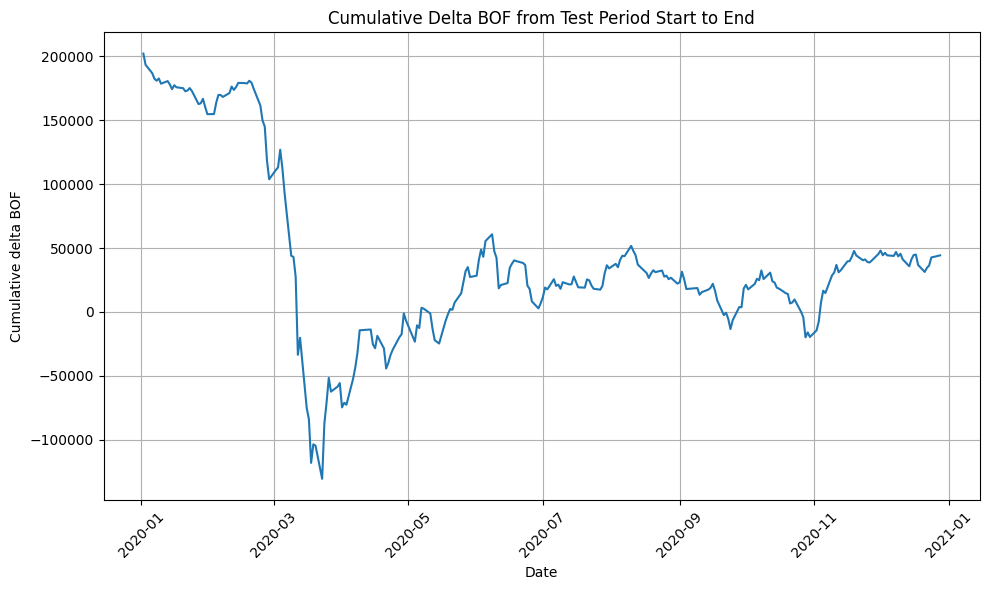

In [ ]:
# Suppose delta_bof is a pandas Series with a datetime index:
# For example:
# delta_bof = pd.Series(data_array, index=date_index)

# 1. Transform the daily delta_bof to a rolling 252-day basis.
#    Here, we compute the rolling sum over 252 days.


# 2. Determine the test period.
# Assume that returns_df contains historical data and test_returns_df contains the test period.
# Let test_start be the first date in test_returns_df.
test_start_date = test_returns_df.index[0]
test_end_date = test_returns_df.index[-1]

# Option A: If you want the rolling measure only for the test period,
# you can extract it from the rolling_delta_bof Series:
rolling_test = rolling_delta_bof.loc[test_start_date:test_end_date]

# Option B: If you instead want to calculate the cumulative delta_bof (running sum)
# over the test period (starting at test_start), do this:
delta_bof_test = delta_bof.loc[test_start_date:test_end_date]
cumulative_delta_bof_test = delta_bof_test.cumsum()

# 3. Plot the cumulative delta_bof over the test period.
plt.figure(figsize=(10, 6))
plt.plot(rolling_test.index, rolling_test.values, linestyle='-')
plt.xlabel("Date")
plt.ylabel("Cumulative delta BOF")
plt.title("Cumulative Delta BOF from Test Period Start to End")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
rolling_delta_bof.head(252)

Date
2019-01-03              NaN
2019-01-04              NaN
2019-01-07              NaN
2019-01-08              NaN
2019-01-09              NaN
                  ...      
2019-12-23              NaN
2019-12-24              NaN
2019-12-27              NaN
2019-12-30              NaN
2019-12-31    197589.763081
Length: 252, dtype: float64

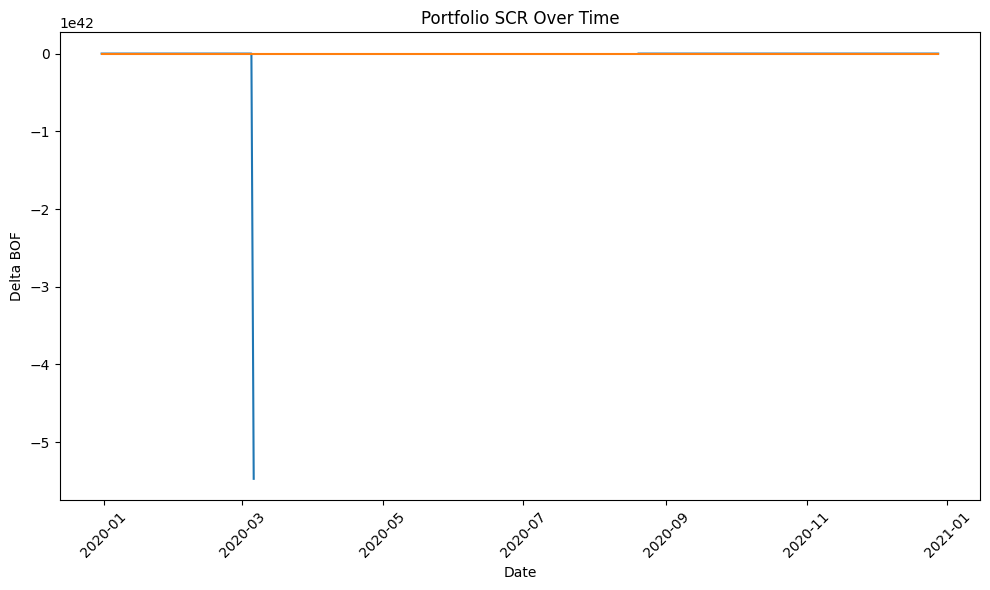

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(sorted_dates, scr_values, linestyle='-')
plt.plot(rolling_delta_bof.index, rolling_delta_bof.values, linestyle='-')
plt.xlabel("Date")
plt.ylabel("Delta BOF")
plt.title("Portfolio SCR Over Time")
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

## RESULTS

Loaded Generated returns from: generated_GAN_output\generated_returns_REEL_final_scenarios.pt
Scaled = False
Loaded Generated returns from: generated_GAN_output\generated_returns_PE_final_scenarios.pt
Scaled = False
Loaded Generated returns from: generated_GAN_output\generated_returns_MSCIWORLD_final_scenarios.pt
Scaled = False
Loaded Generated returns from: generated_GAN_output\generated_returns_IG_final_scenarios.pt
Scaled = False
Loaded Generated returns from: generated_GAN_output\generated_returns_GOV_final_scenarios.pt
Scaled = False
Loaded Generated returns from: generated_GAN_output\generated_returns_HY_final_scenarios.pt
Scaled = False
Loaded Generated returns from: generated_GAN_output\generated_returns_EONIA_final_scenarios.pt
Scaled = False


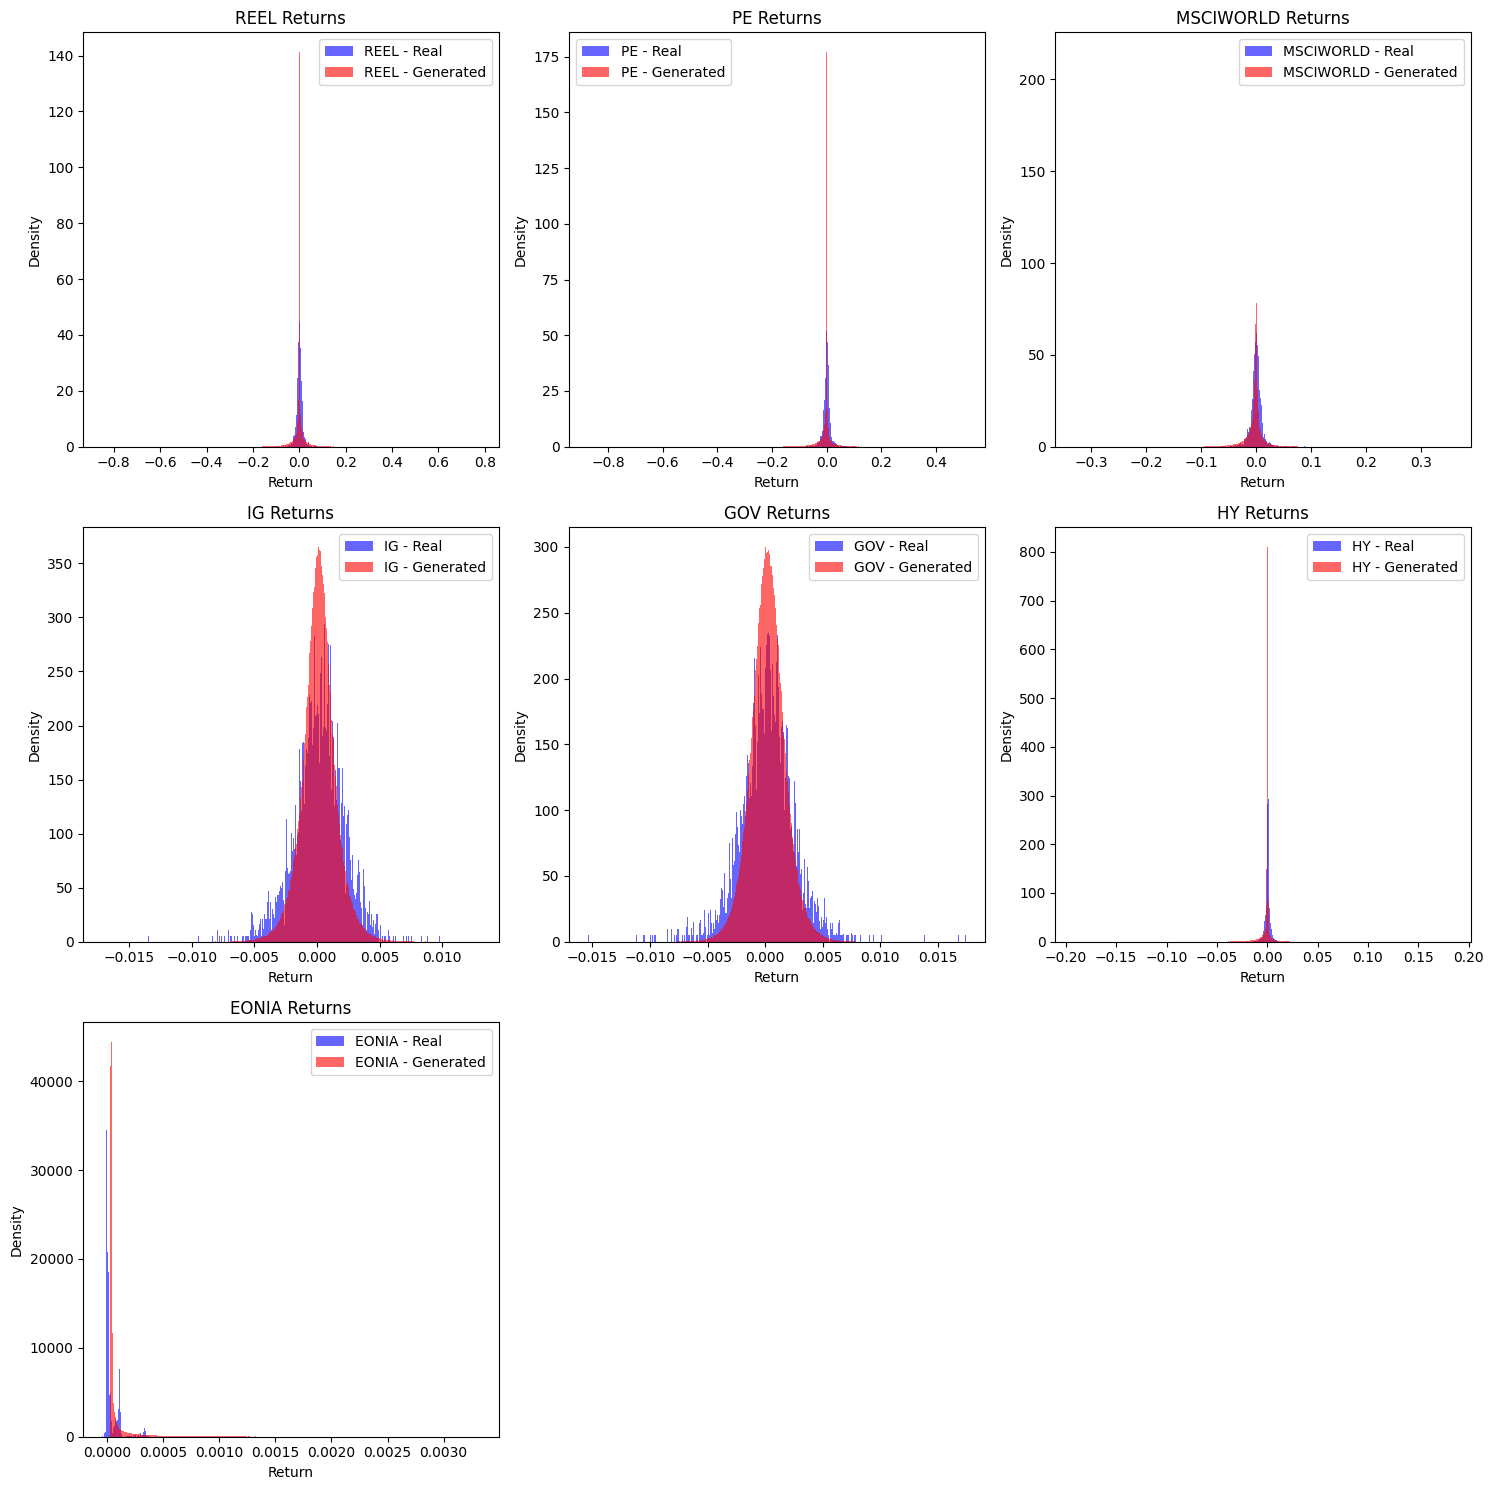


📊 Return Statistics Summary:
                Asset      Mean  Std Dev  Skewness  Kurtosis  99.5% VaR
          REEL - Real  0.000193 0.012916 -0.270455  4.969021  -0.051644
     REEL - Generated -0.001199 0.032212 -0.819827 32.373661  -0.155087
            PE - Real  0.000224 0.012736 -0.303648  6.380382  -0.052287
       PE - Generated -0.004143 0.032162 -3.021978 43.972351  -0.170806
     MSCIWORLD - Real  0.000283 0.009887 -0.226726  7.359869  -0.037021
MSCIWORLD - Generated -0.002159 0.017301 -1.077742 22.970936  -0.084535
            IG - Real  0.000182 0.002083 -0.458256  2.226597  -0.006788
       IG - Generated  0.000156 0.001394  0.030079  2.334459  -0.004131
           GOV - Real  0.000183 0.002449 -0.034370  4.018610  -0.008100
      GOV - Generated  0.000257 0.001532  0.059018  1.268482  -0.004176
            HY - Real  0.000279 0.003002 -1.860565 31.424899  -0.012798
       HY - Generated -0.001085 0.008046 -3.180459 43.078167  -0.047046
         EONIA - Real  0.000032 0.

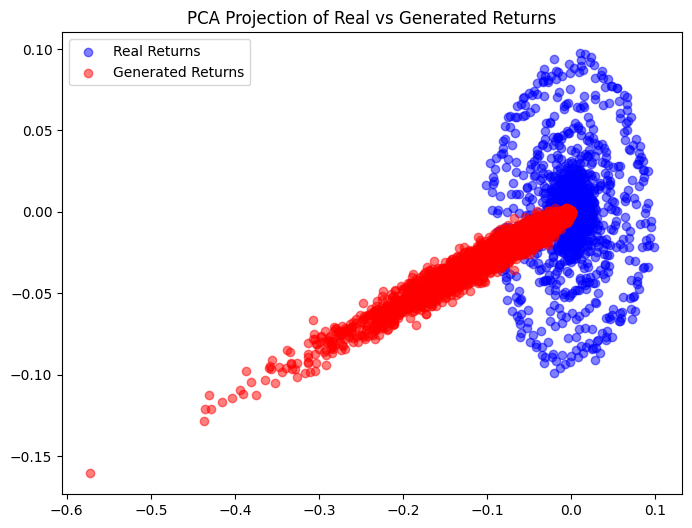

Loaded Generated returns from: generated_GAN_output\generated_returns_REEL_final_scenarios.pt


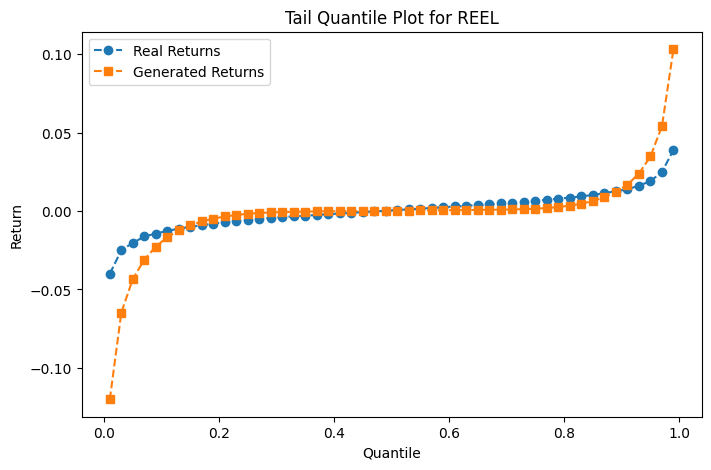


════════════════════════════════════════════════
║  COMPUTING NEAREST DISTANCE HISTOGRAM: REEL  ║
════════════════════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_REEL_final_scenarios.pt

📊 Distance Summary for REEL:
Min Distance: 0.000000
Max Distance: 18.932655
Mean Distance: 0.008885
Median Distance: 0.000205
Standard Deviation: 0.158149


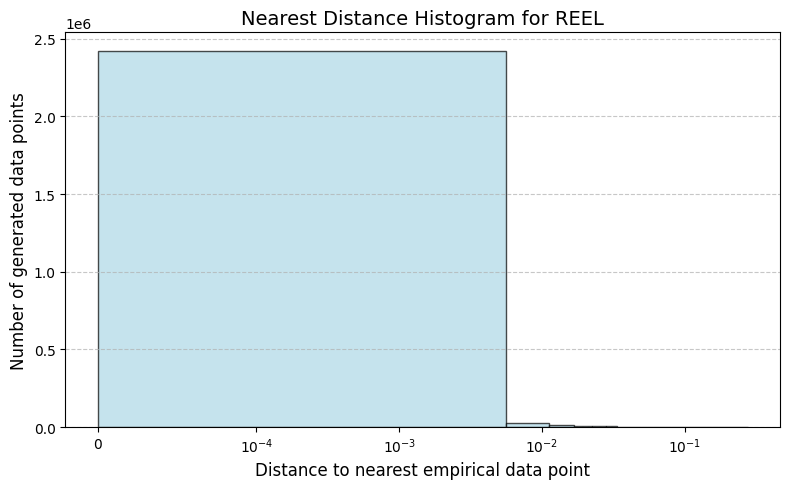


══════════════════════════════════════════
║  COMPUTING WASSERSTEIN DISTANCE: REEL  ║
══════════════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_REEL_final_scenarios.pt
📊 Wasserstein Distance for REEL: 0.008352


═════════════════════════
║  ANALYZING ASSET: PE  ║
═════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_PE_final_scenarios.pt
Variance of Real Data: 0.000162
Variance of Generated Data: 0.000779
✅ Generated Data Shows Reasonable Variance
Mean Pairwise Distance (Real): 0.268750
Mean Pairwise Distance (Generated): 0.381134
✅ Generated samples are reasonably diverse


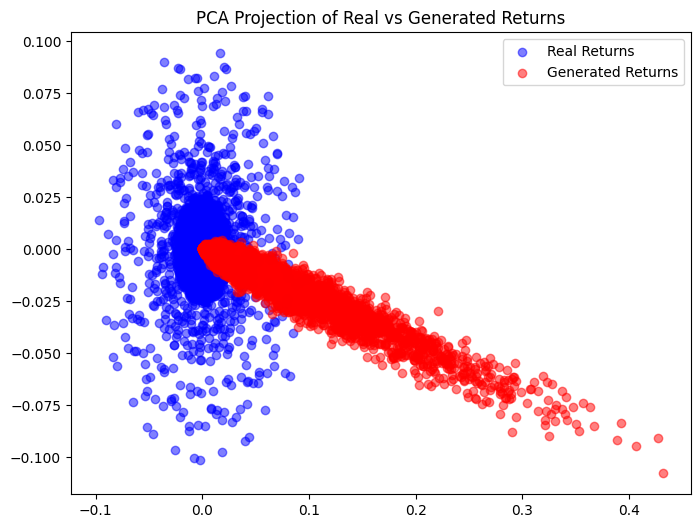

Loaded Generated returns from: generated_GAN_output\generated_returns_PE_final_scenarios.pt


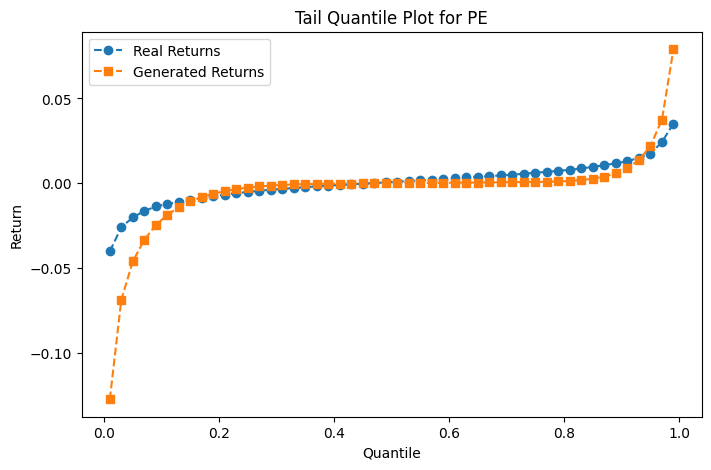


══════════════════════════════════════════════
║  COMPUTING NEAREST DISTANCE HISTOGRAM: PE  ║
══════════════════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_PE_final_scenarios.pt

📊 Distance Summary for PE:
Min Distance: 0.000000
Max Distance: 23.850511
Mean Distance: 0.011436
Median Distance: 0.000183
Standard Deviation: 0.232857


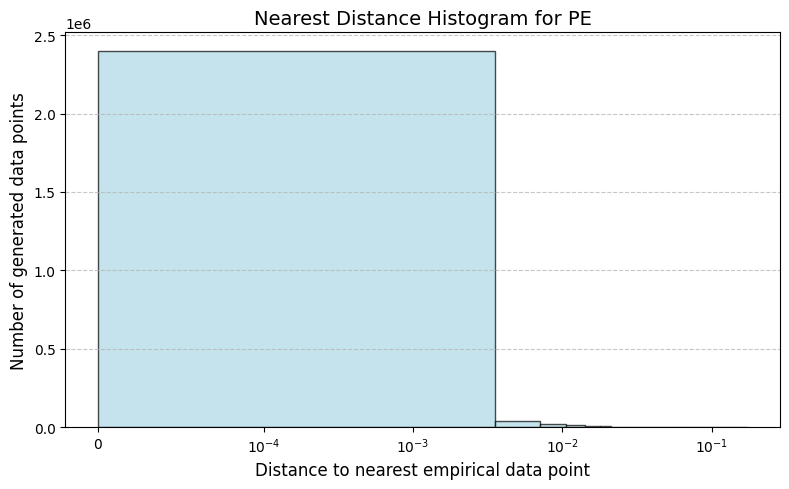


════════════════════════════════════════
║  COMPUTING WASSERSTEIN DISTANCE: PE  ║
════════════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_PE_final_scenarios.pt
📊 Wasserstein Distance for PE: 0.008285


════════════════════════════════
║  ANALYZING ASSET: MSCIWORLD  ║
════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_MSCIWORLD_final_scenarios.pt
Variance of Real Data: 0.000098
Variance of Generated Data: 0.000201
✅ Generated Data Shows Reasonable Variance
Mean Pairwise Distance (Real): 0.211255
Mean Pairwise Distance (Generated): 0.221354
✅ Generated samples are reasonably diverse


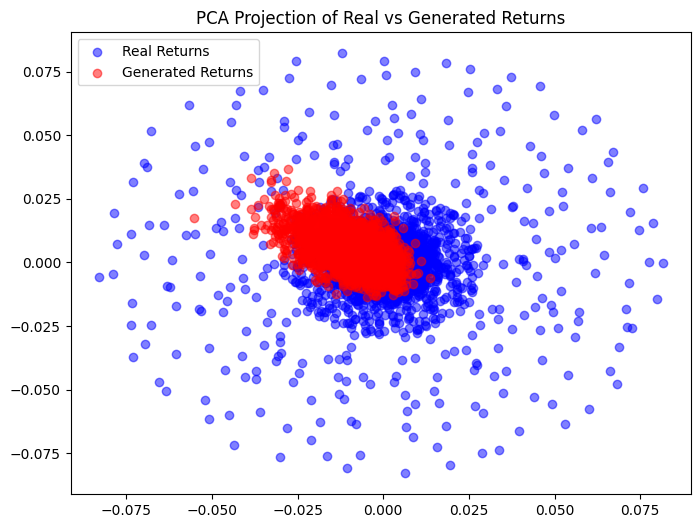

Loaded Generated returns from: generated_GAN_output\generated_returns_MSCIWORLD_final_scenarios.pt


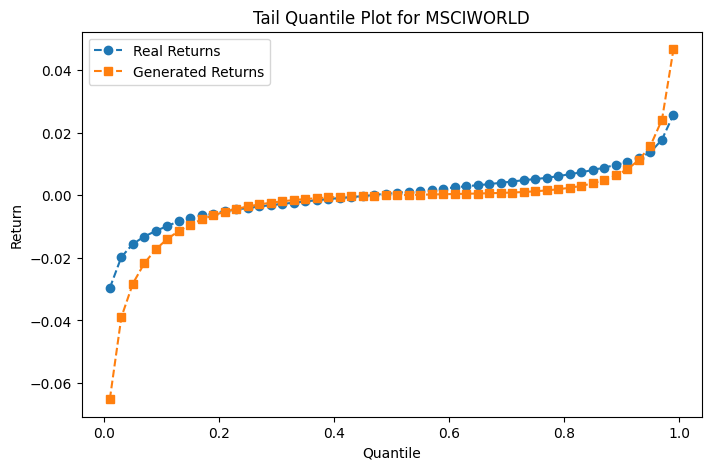


═════════════════════════════════════════════════════
║  COMPUTING NEAREST DISTANCE HISTOGRAM: MSCIWORLD  ║
═════════════════════════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_MSCIWORLD_final_scenarios.pt

📊 Distance Summary for MSCIWORLD:
Min Distance: 0.000000
Max Distance: 12.595591
Mean Distance: 0.004887
Median Distance: 0.000220
Standard Deviation: 0.088036


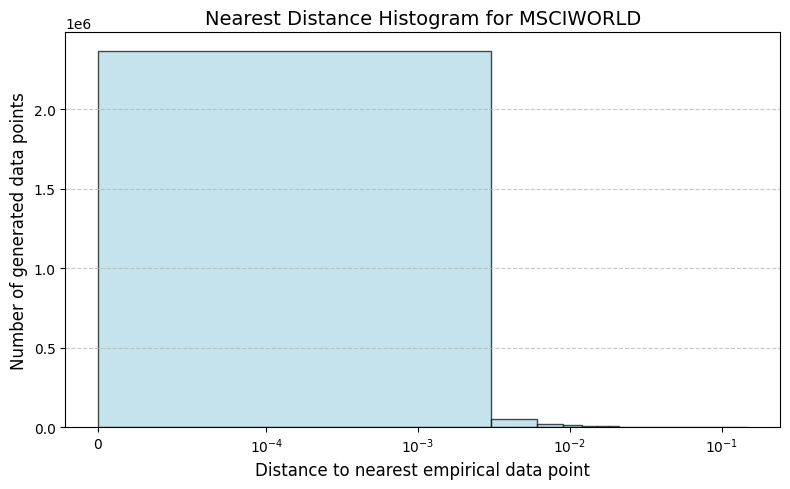


═══════════════════════════════════════════════
║  COMPUTING WASSERSTEIN DISTANCE: MSCIWORLD  ║
═══════════════════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_MSCIWORLD_final_scenarios.pt
📊 Wasserstein Distance for MSCIWORLD: 0.004124


═════════════════════════
║  ANALYZING ASSET: IG  ║
═════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_IG_final_scenarios.pt
Variance of Real Data: 0.000004
Variance of Generated Data: 0.000001
⚠️ Warning: Possible Mode Collapse - Low Variance in Generated Data
Mean Pairwise Distance (Real): 0.046002
Mean Pairwise Distance (Generated): 0.025355
✅ Generated samples are reasonably diverse


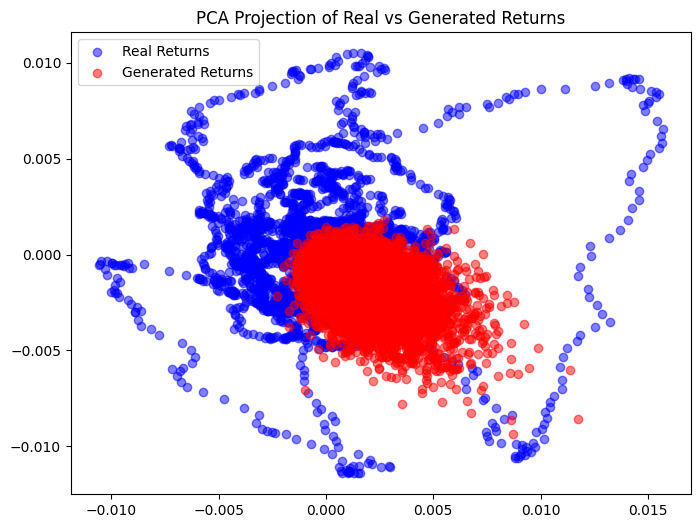

Loaded Generated returns from: generated_GAN_output\generated_returns_IG_final_scenarios.pt


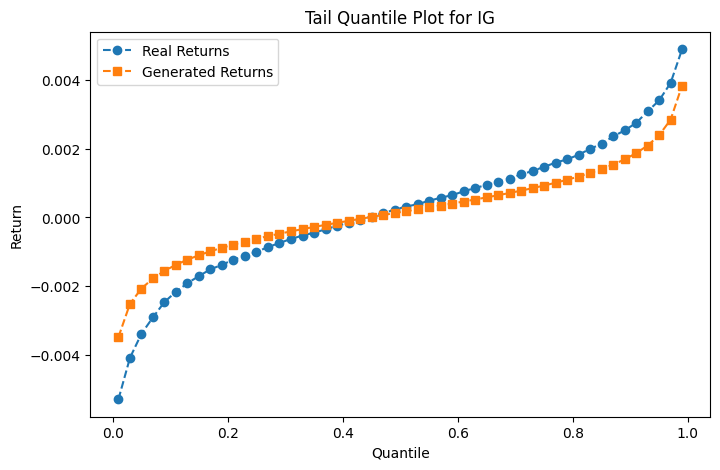


══════════════════════════════════════════════
║  COMPUTING NEAREST DISTANCE HISTOGRAM: IG  ║
══════════════════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_IG_final_scenarios.pt

📊 Distance Summary for IG:
Min Distance: 0.000000
Max Distance: 6.007556
Mean Distance: 0.002026
Median Distance: 0.000356
Standard Deviation: 0.028125


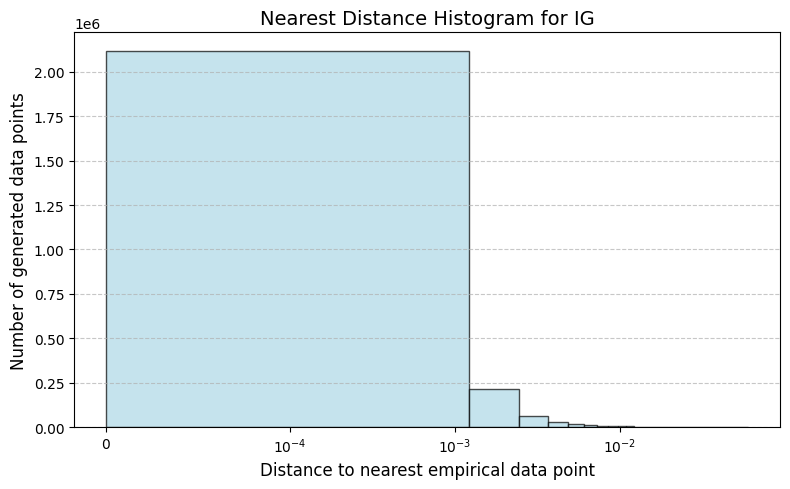


════════════════════════════════════════
║  COMPUTING WASSERSTEIN DISTANCE: IG  ║
════════════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_IG_final_scenarios.pt
📊 Wasserstein Distance for IG: 0.000541


══════════════════════════
║  ANALYZING ASSET: GOV  ║
══════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_GOV_final_scenarios.pt
Variance of Real Data: 0.000006
Variance of Generated Data: 0.000002
⚠️ Warning: Possible Mode Collapse - Low Variance in Generated Data
Mean Pairwise Distance (Real): 0.054322
Mean Pairwise Distance (Generated): 0.029437
✅ Generated samples are reasonably diverse


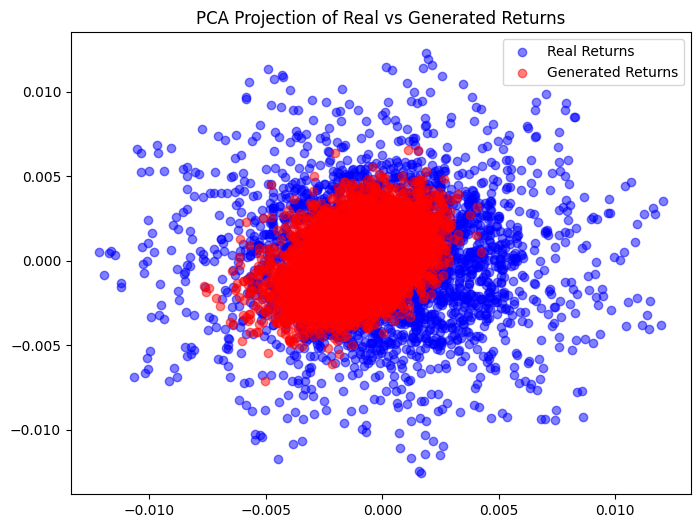

Loaded Generated returns from: generated_GAN_output\generated_returns_GOV_final_scenarios.pt


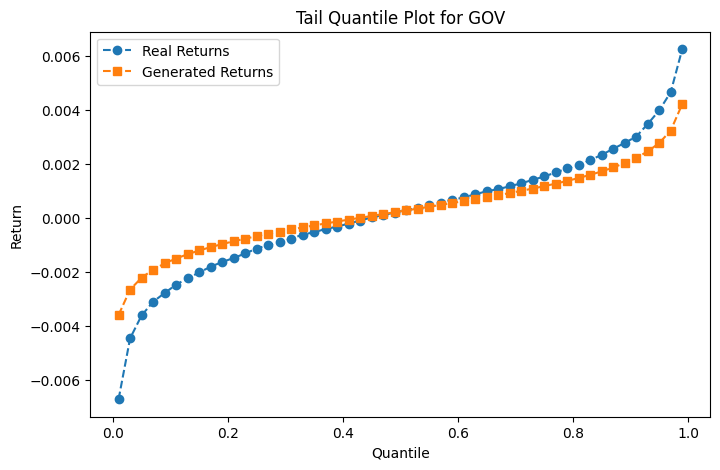


═══════════════════════════════════════════════
║  COMPUTING NEAREST DISTANCE HISTOGRAM: GOV  ║
═══════════════════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_GOV_final_scenarios.pt

📊 Distance Summary for GOV:
Min Distance: 0.000000
Max Distance: 2.032271
Mean Distance: 0.001367
Median Distance: 0.000353
Standard Deviation: 0.008196


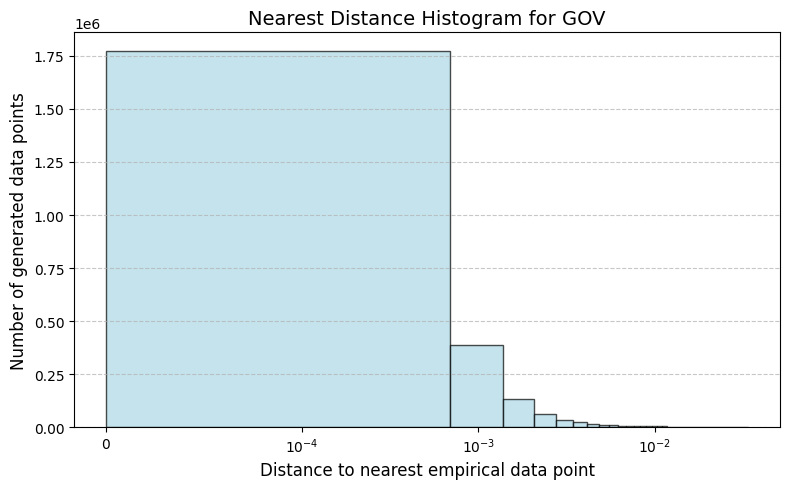


═════════════════════════════════════════
║  COMPUTING WASSERSTEIN DISTANCE: GOV  ║
═════════════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_GOV_final_scenarios.pt
📊 Wasserstein Distance for GOV: 0.000614


═════════════════════════
║  ANALYZING ASSET: HY  ║
═════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_HY_final_scenarios.pt
Variance of Real Data: 0.000009
Variance of Generated Data: 0.000056
✅ Generated Data Shows Reasonable Variance
Mean Pairwise Distance (Real): 0.060213
Mean Pairwise Distance (Generated): 0.093338
✅ Generated samples are reasonably diverse


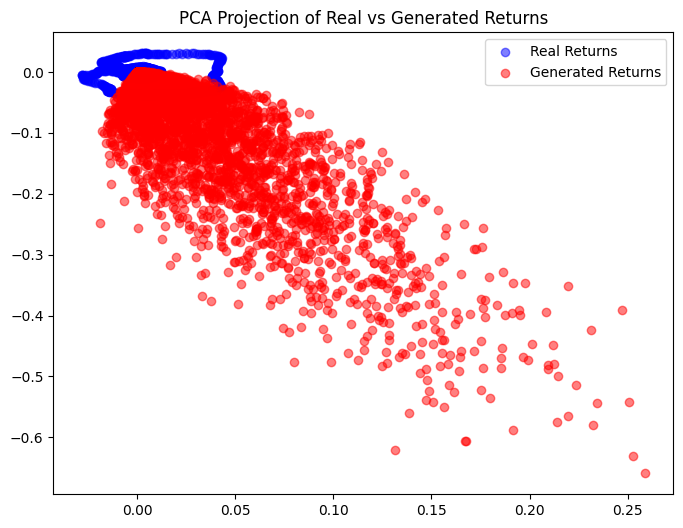

Loaded Generated returns from: generated_GAN_output\generated_returns_HY_final_scenarios.pt


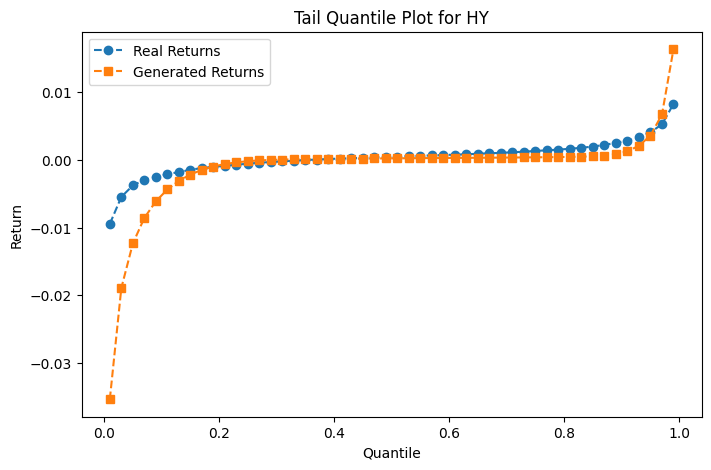


══════════════════════════════════════════════
║  COMPUTING NEAREST DISTANCE HISTOGRAM: HY  ║
══════════════════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_HY_final_scenarios.pt

📊 Distance Summary for HY:
Min Distance: 0.000000
Max Distance: 14.047552
Mean Distance: 0.005426
Median Distance: 0.000130
Standard Deviation: 0.095082


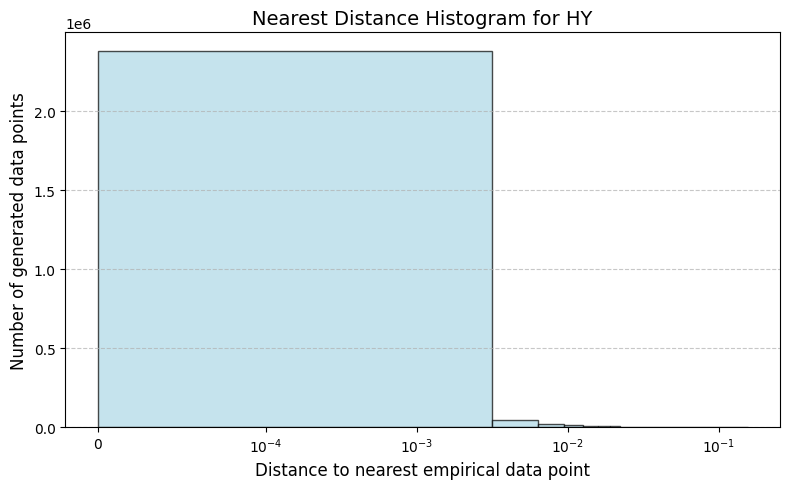


════════════════════════════════════════
║  COMPUTING WASSERSTEIN DISTANCE: HY  ║
════════════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_HY_final_scenarios.pt
📊 Wasserstein Distance for HY: 0.001982


════════════════════════════
║  ANALYZING ASSET: EONIA  ║
════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_EONIA_final_scenarios.pt
Variance of Real Data: 0.000000
Variance of Generated Data: 0.000000
✅ Generated Data Shows Reasonable Variance
Mean Pairwise Distance (Real): 0.001171
Mean Pairwise Distance (Generated): 0.002616
✅ Generated samples are reasonably diverse


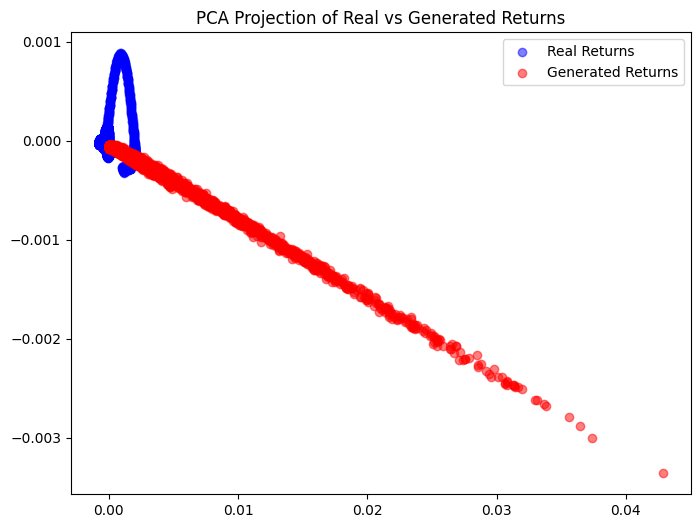


═══════════════════════════════════════════
║  COMPUTING WASSERSTEIN DISTANCE: EONIA  ║
═══════════════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_EONIA_final_scenarios.pt
📊 Wasserstein Distance for EONIA: 0.000089



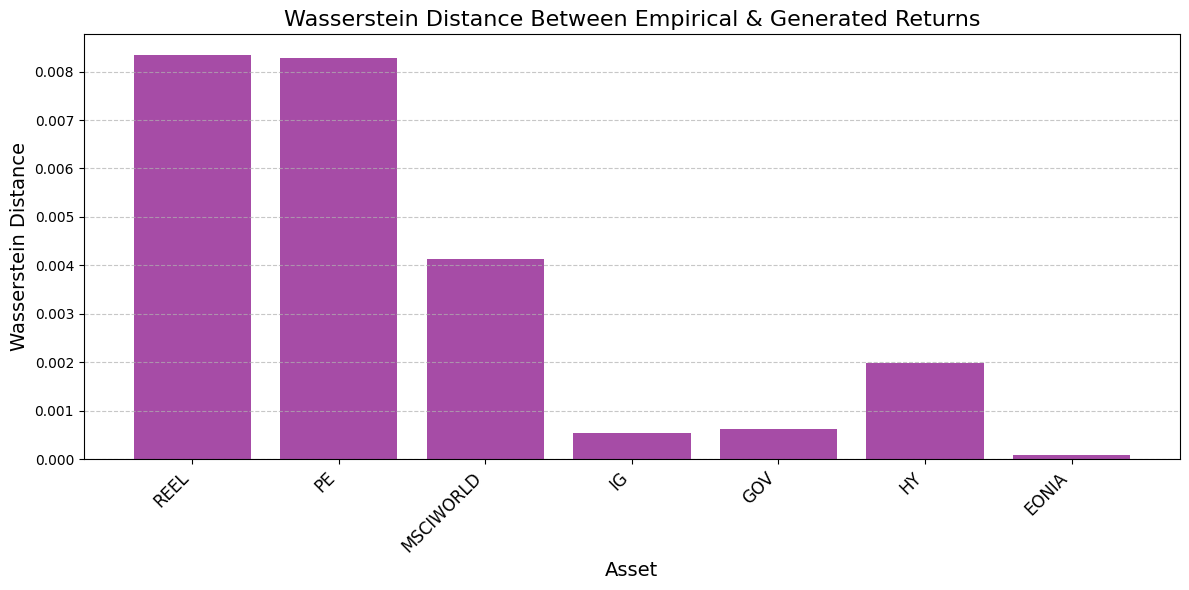

In [ ]:
extensive_plotting(scaled=False, returns_df=returns_df, test=False, quarterly=False)

# ----------------------------------------------------------

In [ ]:
from utilities.load_generated_quarters import load_all_generated_quarters

In [ ]:
for asset_name in returns_df.columns:
    # Create a new function that loads all fucking quarter for a fucking asset
    generated_returns = load_all_generated_quarters(asset_name, quarterly=True, test=True)

    failures, var_thresholds = backtest_var_single_asset(test_returns_df[asset_name], generated_returns, asset_name, quarterly=True)

    perform_var_backtesting_tests(failures=failures, returns=test_returns_df[asset_name], var_forecast=var_thresholds, asset_name=asset_name, generated_returns=generated_returns)


    perform_distribution_tests(generated_returns=generated_returns[0], empirical_returns_rolling=create_rolling_empirical(returns_df[asset_name]), asset_name = asset_name)


FileNotFoundError: [Errno 2] No such file or directory: 'generated_CGAN_output_test\\q0\\generated_returns_REEL_q0.pt'